In [44]:
import numpy as np
import pandas as pd
import os
import re
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 18

In [45]:
MAIN_DIR = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/'
images_df = pd.read_csv(MAIN_DIR+'images.csv')
styles_df = pd.read_csv(MAIN_DIR+'styles.csv', on_bad_lines='skip')

In [46]:
images_df.head()

,filename,link
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...
2,59263.jpg,http://assets.myntassets.com/v1/images/style/p...
3,21379.jpg,http://assets.myntassets.com/v1/images/style/p...
4,53759.jpg,http://assets.myntassets.com/v1/images/style/p...


In [47]:
styles_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [48]:
styles_df['filename'] = styles_df['id'].astype(str) + '.jpg'
styles_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg


In [49]:
image_files = os.listdir(MAIN_DIR+'images')

In [50]:
styles_df['present'] = styles_df['filename'].apply(lambda x: x in image_files)
styles_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,present
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg,True
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg,True
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg,True
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg,True
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg,True


In [51]:
styles_df['present'].value_counts()

present
True     44419
False        5
Name: count, dtype: int64

In [52]:
styles_df = styles_df[styles_df['present']].reset_index(drop=True)

In [53]:
styles_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,present
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg,True
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg,True
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg,True
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg,True
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg,True


In [54]:
styles_df.shape

(44419, 12)

In [55]:
styles = styles_df.sample(10000,random_state = 30).reset_index(drop=True)
styles.shape

(10000, 12)

In [56]:
from PIL import Image

image_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/14782.jpg'
image_sample = Image.open(image_path)
'''plt.imshow(image_sample)
plt.axis('off')
plt.show()'''

width, height = image_sample.size
number_of_pixel = width*height

number_of_channel = len(image_sample.getbands())

print(f"Resmin boyutu: {width}x{height} piksel")
print(f"Toplam piksel sayısı: {number_of_pixel}")
print(f"Kanal sayısı: {number_of_channel}")


Resmin boyutu: 1800x2400 piksel
Toplam piksel sayısı: 4320000
Kanal sayısı: 3


In [57]:
IMG_SIZE = (224,224)
datagen = ImageDataGenerator(rescale=1/255.)
generator = datagen.flow_from_dataframe(dataframe=styles,
                                        directory=MAIN_DIR+'images',
                                        target_size=IMG_SIZE,
                                        x_col='filename',
                                        class_mode=None,
                                        batch_size=32,
                                        shuffle=False)

Found 10000 validated image filenames.


![](https://blog.paperspace.com/content/images/size/w1000/2021/05/image-32.png)

![](https://image.slidesharecdn.com/classificationusingcnn-170430184308/75/object-classification-using-cnn-vgg16-model-keras-and-tensorflow-14-2048.jpg?cb=1666605193)

In [58]:
base_model = VGG16(include_top=False, input_shape=IMG_SIZE+(3,))
base_model.trainable = False 

### The VGG16 model is loaded and the upper layers (fully connected layers) are not included. This allows the model to transform an image into lower level features (edges, textures, etc.) using its pre-trained weights.

### Trainable feature hierarchy (<font color = red>Low-level</font>, <font color = blue>Mid-level</font> , <font color = purple>High-level</font> )
### – <font color = red>pixel</font>  → <font color = red>edge</font>  → <font color = blue>texton</font>  → <font color = blue>motif</font>  → <font color = purple>part</font>  → <font color = purple>object</font> 

![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*Nf7zOyC2OaNFhKIf.png)

In [59]:
input_layer = Input(shape=IMG_SIZE+(3,))
x = base_model(input_layer)
output = GlobalAveragePooling2D()(x)

embeddings = Model(input_layer, output)
embeddings.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
Total params: 14714688 (56.13 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


### 1. Input Layer: 224x224x3
### ---------------- VGG16 ----------------
### 2. 2 Convolutional Layer: 224x224x64
### 3. Max Pooling: 112x112x64
### 4. 2 Convolutional Layer: 112x112x128
### 5. Max Pooling: 56x56x128
### 6. 3 Convolutional Layer: 56x56x256
### 7. Max Pooling: 28x28x256
### 8. 3 Convolutional Layer: 28x28x512
### 9. Max Pooling: 14x14x512
### ---------------- VGG16 ----------------
### 10. GlobalAveragePooling2D: 512

In [60]:
from keras.models import load_model

embeddings.save('trained_model.h5')
loaded_model = load_model('trained_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [61]:
X = loaded_model.predict(generator, verbose=1)

313/313 [==============================] - 169s 539ms/step


In [62]:
from sklearn.decomposition import PCA

pca = PCA(2)
X_pca = pca.fit_transform(X)

![](https://www.mdpi.com/materials/materials-16-05577/article_deploy/html/images/materials-16-05577-g001-550.jpg)

### • Reduces time complexity: Less computation
### • Reduces space complexity: Less parameters
### • Saves the cost of observing the feature
### • Simpler models are more robust on small datasets
### • More interpretable; simpler explanation
### • Data visualization (structure, groups, outliers, etc ) if plotted in 2 or 3 dimensions

In [63]:
X_pca.shape

(10000, 2)

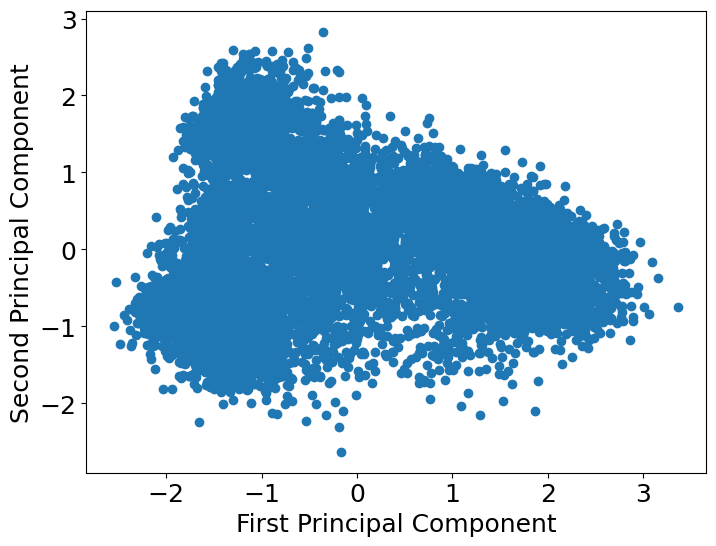

In [64]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.show()


In [65]:
styles[['pc1','pc2']] = X_pca

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

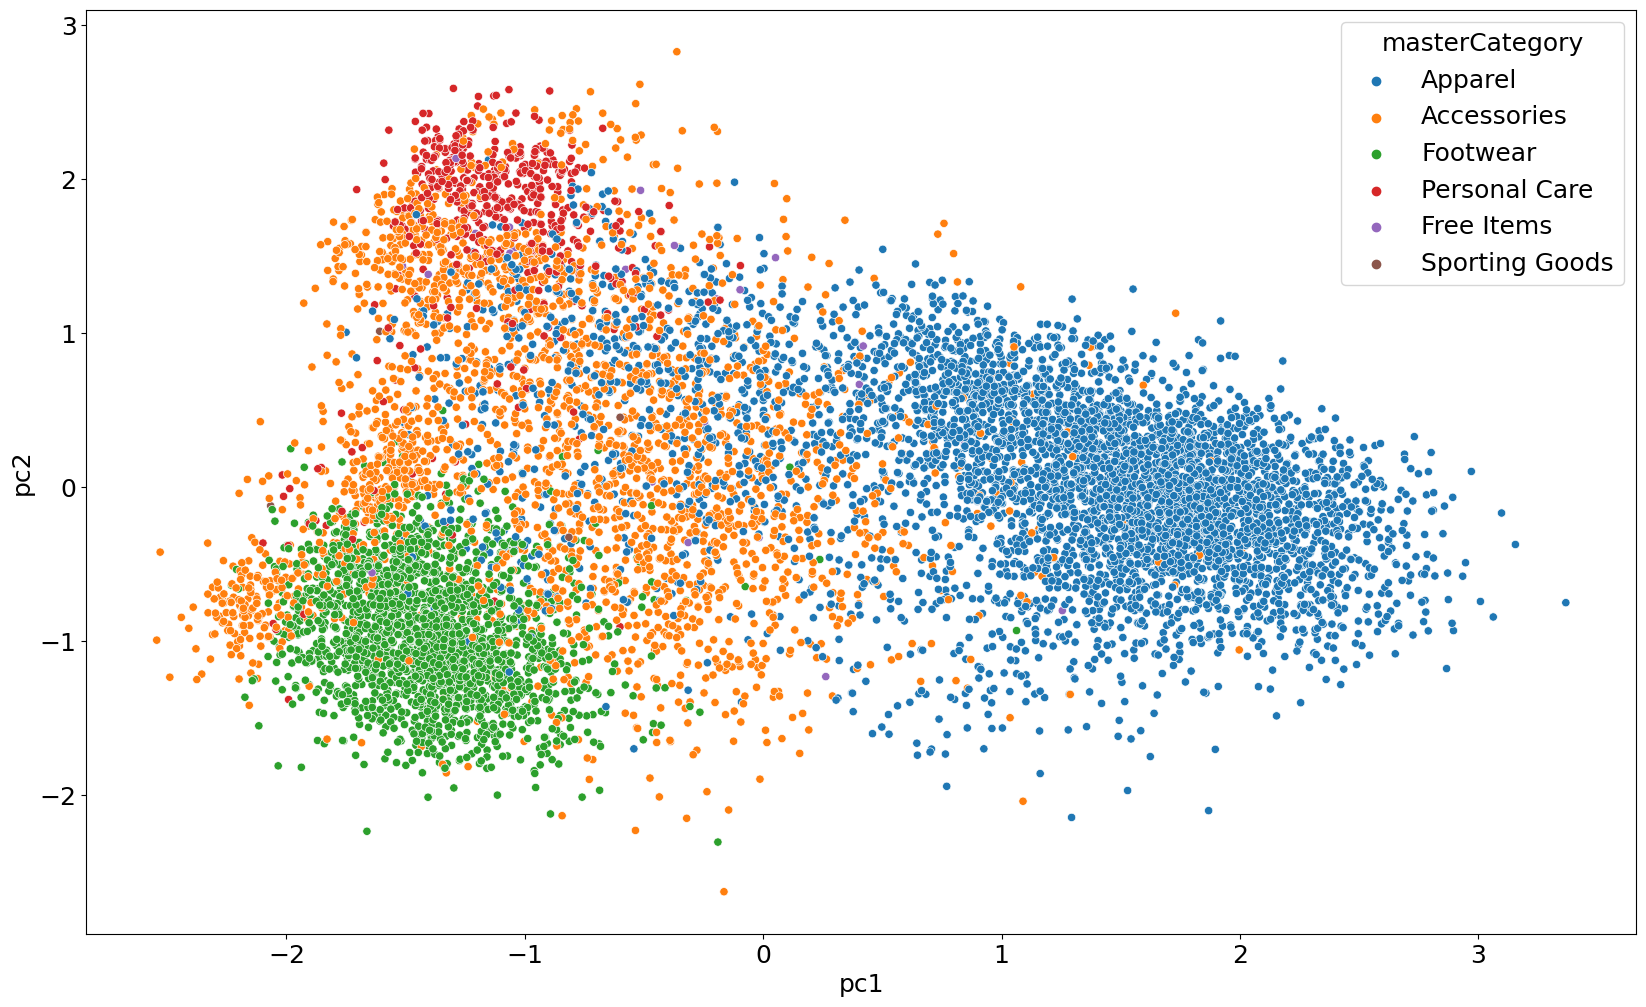

In [66]:
plt.figure(figsize=(20,12))
sns.scatterplot(x='pc1',y='pc2', data=styles, hue='masterCategory')
plt.show()

In [67]:
def read_img(image_path):
    path = MAIN_DIR + 'images/'
    image = load_img(os.path.join(path,image_path),target_size=(224,224,3))
    image = img_to_array(image)
    image = image/255.
    return image

In [68]:
import random
from sklearn.neighbors import KNeighborsClassifier
y = styles['id']


# **K-Nearest Neighbors**

The **k-nearest neighbor algorithm**, also known as **k-NN**, is a supervised learning classifier that uses proximity to make classifications or predictions about the grouping of data points.

Goal of the algorithm is to predict the class of a data point. It does this by selecting the class to which the majority of the closest data points belong.

Graph below shows a set of data points and their classes <font color = orange> A </font> and  <font color = purple> B </font>. The star represents the new data point. The value k, which is also in the name of the algorithm, indicates the k closest points to the data. For k=3 we get a class B prediction, for k = 6 we get a class <font color = orange> A </font> prediction.

#### Visualization of the K-Nearest Neighbor algorithm

<img src="https://i.hizliresim.com/2tlip6g.png" width = "500" >


In [69]:
nn_pca = KNeighborsClassifier(n_neighbors=6)
nn_pca.fit(X_pca,y)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


KNeighborsClassifier(n_neighbors=6)

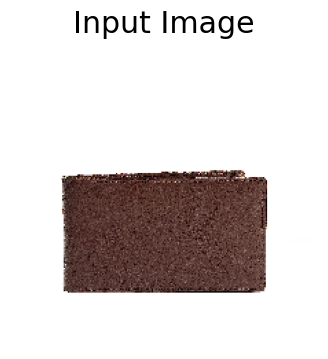

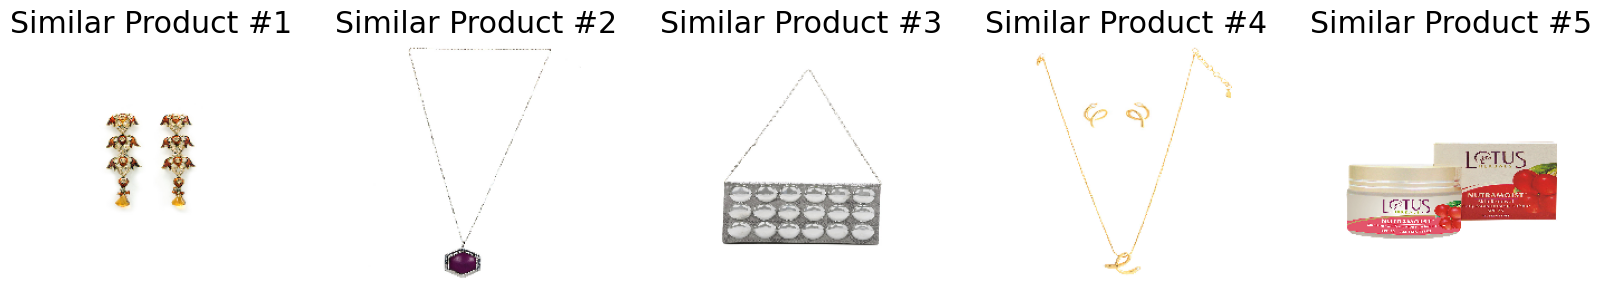

In [70]:
for _ in range(1):
    i = random.randint(0,len(styles))
    img1 = read_img(styles.loc[i,'filename'])
    dist, index = nn.kneighbors(X=X_pca[i,:].reshape(1,-1))
    plt.figure(figsize = (4 , 4))
    plt.imshow(img1)
    plt.title("Input Image")
    plt.axis('off')

    plt.figure(figsize = (20 , 20))
    for i in range(1,6):
        plt.subplot(1 , 5, i)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = read_img(styles.loc[index[0][i],'filename'])
        plt.imshow(image)
        plt.title(f'Similar Product #{i}')
        plt.axis('off')

In [71]:
nn = KNeighborsClassifier(n_neighbors=6)
nn.fit(X,y)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


KNeighborsClassifier(n_neighbors=6)

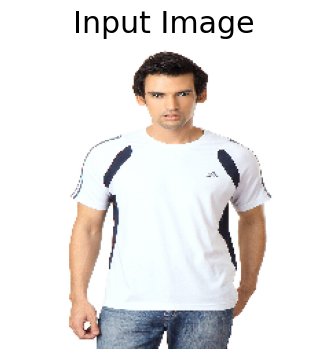

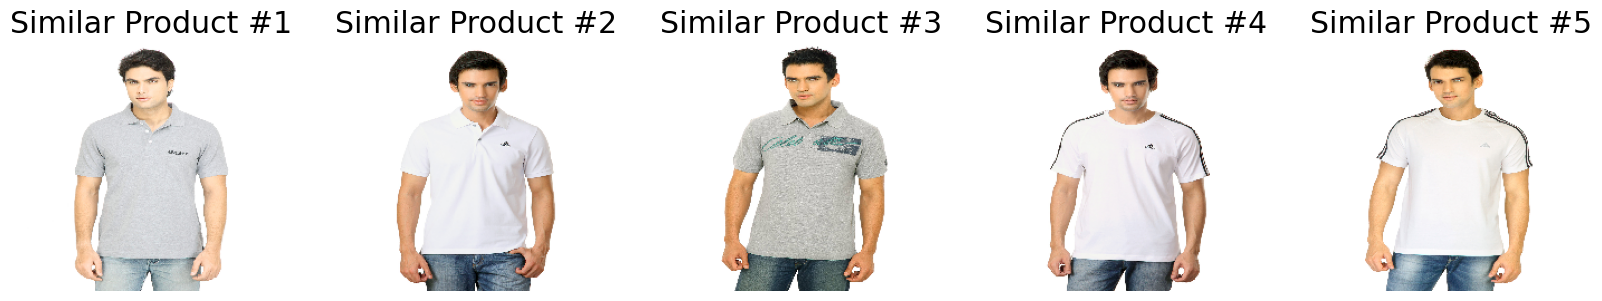

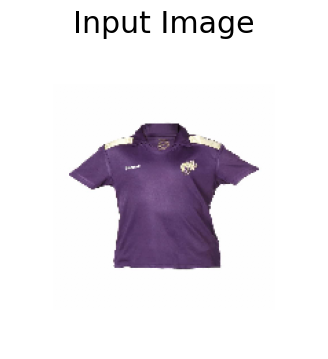

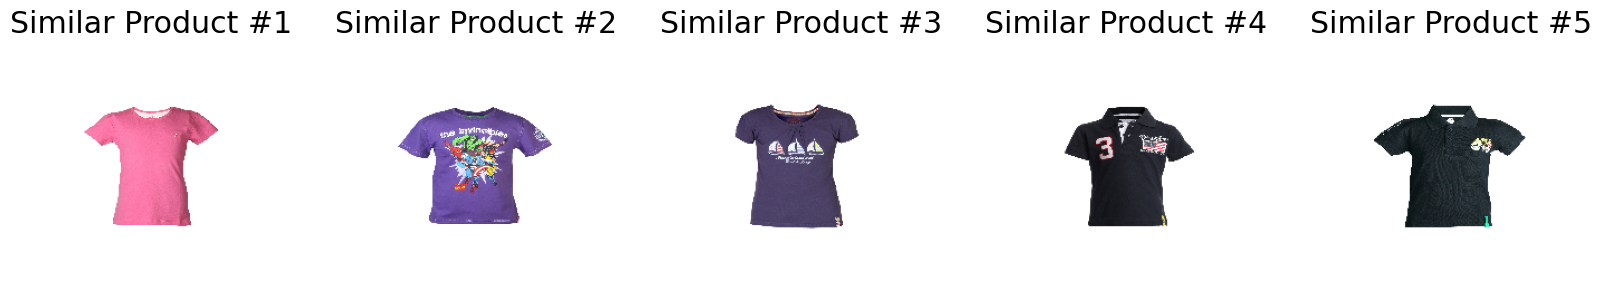

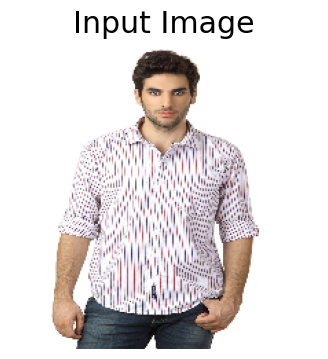

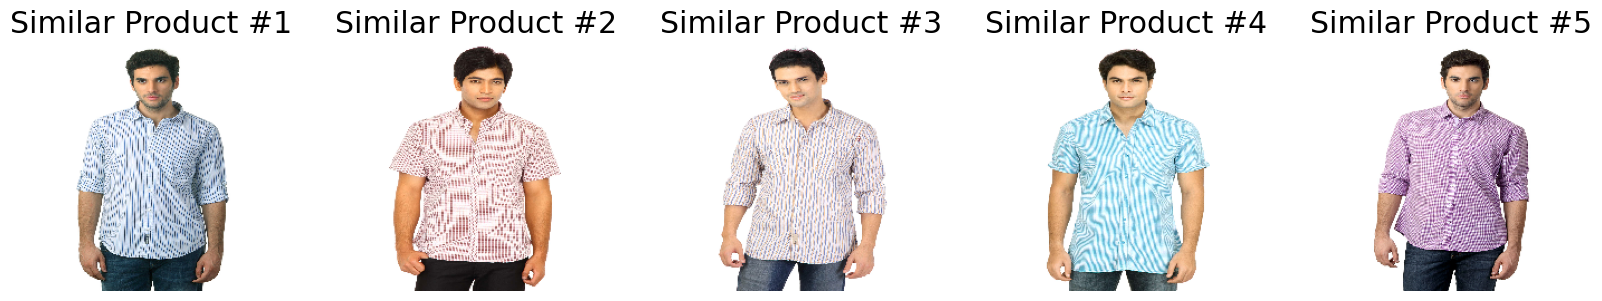

In [93]:
for _ in range(3):
    i = random.randint(0,len(styles))
    img1 = read_img(styles.loc[i,'filename'])
    dist, index = nn.kneighbors(X=X[i,:].reshape(1,-1))
    plt.figure(figsize = (4 , 4))
    plt.imshow(img1)
    plt.title("Input Image")
    plt.axis('off')

    plt.figure(figsize = (20 , 20))
    for i in range(1,6):
        plt.subplot(1 , 5, i)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = read_img(styles.loc[index[0][i],'filename'])
        plt.imshow(image)
        plt.title(f'Similar Product #{i}')
        plt.axis('off')

In [73]:
styles.tail()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,present,pc1,pc2
9995,8940,Men,Apparel,Topwear,Shirts,Red,Fall,2011.0,Casual,Indigo Nation Men Reversible Bling Red Shirts,8940.jpg,True,2.946565,-0.491594
9996,38994,Boys,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Gini and Jony Boys Jeans Blue Jeans,38994.jpg,True,-0.248073,1.266091
9997,56282,Women,Apparel,Innerwear,Bra,Black,Summer,2017.0,Casual,Biara Black Everyday Support Bra,56282.jpg,True,1.293867,-2.146941
9998,25161,Women,Accessories,Bags,Handbags,Black,Winter,2015.0,Casual,Lino Perros Women Leatherette Black Handbag,25161.jpg,True,-0.232142,0.053888
9999,4046,Men,Footwear,Shoes,Sports Shoes,White,Summer,2011.0,Sports,ADIDAS Men's Allegra 4M White Navy Blue Black ...,4046.jpg,True,-1.274387,-0.953828


In [74]:
len(styles['id'].unique())

10000

In [75]:
product_list = styles['id'].unique()

In [76]:
product_list[0]

48441

In [77]:
input_image = styles.loc[styles.index[styles['id'] == 10].tolist(),'filename']

In [78]:
input_image

Series([], Name: filename, dtype: object)

In [79]:
styles[styles['id'] == product_list[0]]['filename']

0    48441.jpg
Name: filename, dtype: object

In [80]:
styles.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,present,pc1,pc2
0,48441,Men,Apparel,Topwear,Tshirts,White,Summer,2012.0,Casual,French Connection Men White Printed T-shirt,48441.jpg,True,0.760321,0.649946
1,40051,Men,Apparel,Topwear,Jackets,Navy Blue,Fall,2013.0,Sports,ADIDAS Men Navy Messi Track Jacket,40051.jpg,True,1.349681,-0.366391
2,12327,Men,Apparel,Topwear,Shirts,Pink,Winter,2011.0,Formal,Genesis Pink Striped Formal Shirt,12327.jpg,True,1.815399,-0.065858
3,41527,Men,Accessories,Bags,Messenger Bag,Brown,Summer,2012.0,Casual,Basics Men Brown Messenger Bag,41527.jpg,True,-0.336281,-0.610104
4,17420,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Casio Enticer Men Black Dial Analogue Watch A479,17420.jpg,True,-0.213904,-0.173731


In [81]:
image_dict = {}
for j in product_list:
    i = styles.index[styles['id'] == j]
    dist, index = nn.kneighbors(X=X[i,:].reshape(1,-1))
    recommended_images = [styles.loc[index[0][k],'filename'] for k in range(1,6)]
    image_dict[j] = recommended_images

In [82]:
len(image_dict)

10000

In [83]:
product_list[9999],image_dict[product_list[9999]]

(4046, ['15314.jpg', '4048.jpg', '15374.jpg', '12973.jpg', '6675.jpg'])

In [84]:
ratings = {}
scored_dict = {}
index = 0
for sublist in image_dict.values():
    for item in sublist:
        ratings[item] = random.randint(0, 1) if random.random() < random.choice([0.2, 0.4, 0.6, 0.8]) else None
    scored_dict[product_list[index]] = ratings
    ratings = {}
    index += 1

In [85]:
list(scored_dict.keys())[9999],scored_dict[list(scored_dict.keys())[9999]]

(4046,
 {'15314.jpg': 1,
  '4048.jpg': 1,
  '15374.jpg': 0,
  '12973.jpg': 1,
  '6675.jpg': None})

In [86]:
count = 0
for j in range(len(scored_dict.keys())):
    for item in list(list(scored_dict.values())[j].values()):
        if item ==1:
            count= count + 1

In [87]:
recomended_products_count = len(list(list(scored_dict.keys())))*5

In [88]:
count, recomended_products_count

(12615, 50000)

In [89]:
model_success = count/recomended_products_count

In [90]:
model_success

0.2523